# Recap

'df_SFtime.csv' is the time series version of "df_SF" which contains features that relate to air quality related to wildfires from various weather stations around San Francisco. My goal is to target feature 'DS_PM_pred', which is Mean estimated 24-hour average PM2.5 concentration in μg/m3.

The numerical features are:
<ul>
  <li>'tmpf' tempature</li>
  <li>'relh': humidity</li>
  <li>'drct': wind direction</li>
  <li>'sped': wind speed.</li>
</ul>

The only categorical feature relates to the location data.

# Models and Set Up

To make this time series prediction, the following will be used:
<ul>
  <li>train test split via appropriate unsuffled split</li>
  <li>min-max scaling</li>
  <li>4 models
    <ol>
      <li>LSTM</li>
      <li>linear regression</li>
      <li>ridge regression</li>
      <li>lasso regression</li>
    </ol>
  </li>
  <li>root mean squared error as comparison.</li>
</ul> 

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('df_SFtime.csv')

In [4]:
df.columns

Index(['DS_PM_pred', 'lon', 'lat', 'tmpf', 'relh', 'drct', 'sped'], dtype='object')

In [4]:
df=df.drop(['lon','lat'],axis=1)

In [5]:
X = df.drop(['DS_PM_pred'],axis=1)
y = df['DS_PM_pred']

# LSTM

For the LSTM model, I will be using an 80% training and testing split that is unshuffled to prevent future information leak. Then the min-max scaler is applied. I need to make sure that the input shape is appropriate for LSTM. The model will have two layers, one with 50 nodes and a dense layer for 1 node for the 1 prediction output.

In [5]:
train_ind = int(len(df)*0.8)
train = df[:train_ind]
test = df[train_ind:]
train_X, train_y = train.drop(['DS_PM_pred'],axis=1), train['DS_PM_pred']
test_X, test_y = test.drop(['DS_PM_pred'],axis=1), test['DS_PM_pred']
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
train_X, test_X = scaler.transform(train_X), scaler.transform(test_X)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3332044, 1, 6) (3332044,) (833012, 1, 6) (833012,)


In [12]:
train_X.shape[0]

3332044

In [6]:
# Model definition
model = Sequential()

# Adding a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(train_X.shape[1], train_X.shape[2])))

# First LSTM layer with dropout
model.add(LSTM(30, return_sequences=True))  
model.add(Dropout(0.5))

# Second LSTM layer with dropout
model.add(LSTM(20))  
model.add(Dropout(0.5))

# Output layer
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

C:\Users\Whyme\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
history = model.fit(train_X, train_y, epochs=40, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/40
46279/46279 - 67s - 1ms/step - loss: 2.1113 - val_loss: 3.0918
Epoch 2/40
46279/46279 - 65s - 1ms/step - loss: 2.0435 - val_loss: 3.0947
Epoch 3/40
46279/46279 - 65s - 1ms/step - loss: 2.1694 - val_loss: 3.0875
Epoch 4/40
46279/46279 - 65s - 1ms/step - loss: 2.1805 - val_loss: 3.1045
Epoch 5/40
46279/46279 - 64s - 1ms/step - loss: 2.1456 - val_loss: 3.0568
Epoch 6/40
46279/46279 - 64s - 1ms/step - loss: 2.2723 - val_loss: 3.0726
Epoch 7/40
46279/46279 - 64s - 1ms/step - loss: 2.0737 - val_loss: 3.0663
Epoch 8/40
46279/46279 - 65s - 1ms/step - loss: 1.8565 - val_loss: 3.1155
Epoch 9/40
46279/46279 - 64s - 1ms/step - loss: 2.0265 - val_loss: 3.0957
Epoch 10/40
46279/46279 - 64s - 1ms/step - loss: 1.8704 - val_loss: 3.0804
Epoch 11/40
46279/46279 - 67s - 1ms/step - loss: 1.9491 - val_loss: 3.0636
Epoch 12/40
46279/46279 - 66s - 1ms/step - loss: 1.9741 - val_loss: 3.0671
Epoch 13/40
46279/46279 - 65s - 1ms/step - loss: 1.9658 - val_loss: 3.0695
Epoch 14/40
46279/46279 - 65s - 1m

Below is the progress of the testing and training loss functions, to gauge performance of the model. MAE is used here as an appropriate measure for regression. Although the training goes down steadily, the testing loss remains relatively consistent. Adding different layers may help with getting the losses to be closer, which is ideal.

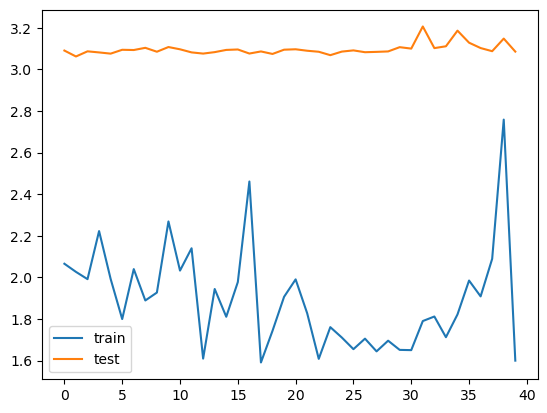

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

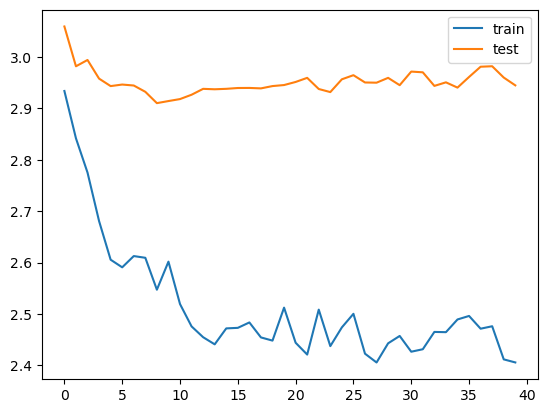

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
#I want to keep the model so that I do not have to run the fitting, which can take over 2 hours.
#import keras
#model.save('lstm1.keras')
#model = keras.models.load_model('path/to/location.keras')

Below are the steps to calculate RMSE. First is the prediction step, then inversion for the scaling that was done below the modeling phases, and finally a square root of the calculated mean square error.

In [22]:
from math import sqrt
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.values.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

26032/26032 ━━━━━━━━━━━━━━━━━━━━ 18s 675us/step
Test RMSE: 228.984


In [30]:
from math import sqrt
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.values.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

26032/26032 ━━━━━━━━━━━━━━━━━━━━ 13s 505us/step
Test RMSE: 0.707


# Regression Models

Pipelines are used to facilate the regression models. They all use a min-max scaler, a time series split, and root mean square error. For Ridge and Lasso, multple alphas are used but I decided on the same $\alpha$'s. Recall that $\alpha$ = 1 gives equivalent to ordinary least squares as in the linear regression model.

In [43]:
pipe = Pipeline([
        ('scale', MinMaxScaler(feature_range=(0, 1))),
        ('reg', LinearRegression())])

param_grid = {}

gsc = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_root_mean_squared_error',
            cv=TimeSeriesSplit(n_splits=8), verbose=10, n_jobs=-1)

gsc.fit(X,y)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('reg', LinearRegression())]),
             n_jobs=-1, param_grid={}, scoring='neg_root_mean_squared_error',
             verbose=10)

In [37]:
gsc.cv_results_

{'mean_fit_time': array([1.5123679]),
 'std_fit_time': array([0.61488805]),
 'mean_score_time': array([0.09830841]),
 'std_score_time': array([0.03397593]),
 'params': [{}],
 'split0_test_score': array([-4.0935294]),
 'split1_test_score': array([-5.3385814]),
 'split2_test_score': array([-33.76625705]),
 'split3_test_score': array([-9.97351079]),
 'split4_test_score': array([-7.64239531]),
 'split5_test_score': array([-4.21608729]),
 'split6_test_score': array([-4.36144641]),
 'split7_test_score': array([-5.33126721]),
 'mean_test_score': array([-9.34038436]),
 'std_test_score': array([9.42451889]),
 'rank_test_score': array([1])}

In [40]:
print(gsc.best_score_)

-9.340384356124469


In [46]:
ridge_pipe = Pipeline([
        ('scale', MinMaxScaler(feature_range=(0, 1))),
        ('ridge', Ridge())])

ridge_pipe_params = {'ridge__alpha':[0.001, 0.01, 0.1, 0, 1, 10]}

gsc = GridSearchCV(ridge_pipe, param_grid = ridge_pipe_params, scoring='neg_root_mean_squared_error',
            cv=TimeSeriesSplit(n_splits=8), verbose=10, n_jobs=-1)

gsc.fit(X,y)

Fitting 8 folds for each of 6 candidates, totalling 48 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 0, 1, 10]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [48]:
print(gsc.best_score_)

-9.339879443407778


In [49]:
lasso_pipe = Pipeline([
        ('scale', MinMaxScaler(feature_range=(0, 1))),
        ('lasso', Lasso())])

lasso_pipe_params = {'lasso__alpha':[0.001, 0.01, 0.1, 0, 1, 10]}

gsc = GridSearchCV(lasso_pipe, param_grid = lasso_pipe_params, scoring='neg_root_mean_squared_error',
            cv=TimeSeriesSplit(n_splits=8), verbose=10, n_jobs=-1)

gsc.fit(X,y)

Fitting 8 folds for each of 6 candidates, totalling 48 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.001, 0.01, 0.1, 0, 1, 10]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [50]:
print(gsc.best_score_)

-8.582539203982401


# Conclusion

We are comparing models to solve a time series prediction on air quality due to wildfires in and around San Francisco.

Here are the RSME's for each model:
  <ol>
      <li>LSTM: 0.707</li>
      <li>linear regression: 9.340</li>
      <li>ridge regression: 9.340</li>
      <li>lasso regression: 8.583</li>
  </ol>

Recall that the closer to 0 that RSME is, the better. The best model in this case is LSTM, which makes sense as the previous notebooks indicated a non-linear relationship.

# Further Steps

Although the relationship between the features and the label are non-linear, more can be done to predict for non-outliers. The spike indicated in previous can be taken out and more time series analysis can be applied to find more seasonality in air quality. Of course, the goal of the project is to predict safe (and unsafe) levels of air due to wildfires, so adding more datasets that use wildfires can also be done. Many things in nature have seasonality, so implementing another model that predicts the seasonality of wildfires can also be done but is surely outside the scope of this current project. 

Further steps like adding more layers to the LSTM, more parameters to the regression models, and other preprocessing methods can be applied. The ideal would be to get the RSME down to at most 0.5. However, without large changes like more added data (including the same data but for different years), the current changes may not lower the RSME enough.

A larger scope can also be implemented, such as adding data from the rest of California. To really test the model's predictive power, we can look at data from other states.

Part of doing this project was learning how to use AWS to do some of the computing. More can be done in the optimizing of this code as well as learning more about AWS.
